In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
import tensorflow as tf
import tensorflow.keras as keras
import copy
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.models import load_model
import copy
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler

In [33]:
'''
LSTM-network for forecasting OC-data.

Cells:
    1: Read data
                    Read the data from column "lineActivated". Count the values and fill missing minutes.
    2: Plot data and investigate

    3: Resample the data
                    Resample the data from minute by minute to hour by hour data.
    
    4: Cut the data
                    Cut the tail and head to the nearest sunday. Only full weeks are studied by the model
    
    5: Normalize the data
                    Normalize data with min-max - method.
    
    6: Split the data
                    Reshape and split the data for machine learning

    7: Subroutines for Machine Learning
                    Forecast:              Forecast the future values
                    Evaluate Forecast:     Evaluates with RMSE the errors of the forecast
                    to_supervised:         Transform data via windowing into much bigger dataset. No need if data is adequate.
                    summarize_scores:      Summarizes the scores
                    evaluate_model:        Evaluates the current model
    
    8: Teaching module
                    Build model builds a customized LSTM network with hidden layers.                         
    9: Plot the model
                    Plot the accuracy and loss from training and validation sets.
    
    10: Denormalize results.

    11: Plot the prediction
                    For visual inspection.

    12: Autocorrelation function
                    Checking the autocorrelation between data and model

'''
#---------------------------------------------------------------
#Read the data to variable OC. Only time is loaded
OC = pd.read_csv("test2018.csv", low_memory=False, parse_dates=['lineActivated'], usecols=['lineActivated'])
print(OC)
# mark all missing values
OC.replace('?', np.nan, inplace=True)
OC.replace('', np.nan, inplace=True)
pd.options.display.max_rows = 10
#---------------------------------------------------------------
#Round the times for nearest minute to further calculate counts
OC['lineActivated'] = OC['lineActivated'].dt.round('min')
#---------------------------------------------------------------
#Frequency table, that is, count per minute. Set all to zero
OC_freq = pd.date_range(start=OC['lineActivated'].min(),
                        end=OC['lineActivated'].max(), freq='T')
OC_freq = pd.DataFrame(OC_freq, columns=['date'])
OC_freq['lineActivated'] = 0
#---------------------------------------------------------------
#Count the occurences into own dataframe with dates
pd.options.display.max_rows = 100
OC_counts = OC['lineActivated'].value_counts()
OC_counts = OC_counts.to_frame()
#---------------------------------------------------------------
#Transform datetime.
OC_counts.reset_index(inplace=True)
OC_counts.columns = ['date','value']
OC_freq['date'] = pd.to_datetime(OC_freq['date']) 
#-------------------------------------------------------------------------------
#Join tables with outer join. That is, if no calls, a zero and minute is added.
OC_freq = pd.merge(OC_freq, OC_counts, on=['date'], how='outer')
OC_freq['value'] = OC_freq['value'].fillna(0).astype(int)
OC_freq = OC_freq.drop('lineActivated', axis=1)
OC_freq_ET=OC_freq['date'].dt.strftime('%d.%m.%Y %H:%M:%S')
#-------------------------------------
print(OC_freq.describe())
#Save the frequency------------------------------
OC_freq.to_csv('OC_freq_edited.csv', index=False)

              lineActivated
0       2023-07-20 14:01:03
1       2023-07-20 14:00:38
2       2023-07-20 14:00:33
3       2023-07-20 14:00:32
4       2023-07-20 14:00:02
...                     ...
2683324 2021-05-10 08:36:16
2683325 2021-05-10 08:36:13
2683326 2021-05-10 08:36:12
2683327 2021-05-10 08:36:11
2683328 2021-05-10 08:36:11

[2683329 rows x 1 columns]
                                date         value
count                        1153766  1.153766e+06
mean   2022-06-14 23:18:29.999996672  2.325713e+00
min              2021-05-10 08:36:00  0.000000e+00
25%              2021-11-26 15:57:15  0.000000e+00
50%              2022-06-14 23:18:30  0.000000e+00
75%              2023-01-01 06:39:45  2.000000e+00
max              2023-07-20 14:01:00  6.500000e+01
std                              NaN  4.365429e+00


In [34]:

#Load file:
import pandas as pd
data = pd.read_csv("OC_freq_edited.csv",parse_dates=['date'])
OC_freq = data.copy()
OC_freq

,date,value
0,2021-05-10 08:36:00,11
1,2021-05-10 08:37:00,26
2,2021-05-10 08:38:00,14
3,2021-05-10 08:39:00,26
4,2021-05-10 08:40:00,26
...,...,...
1153761,2023-07-20 13:57:00,6
1153762,2023-07-20 13:58:00,3
1153763,2023-07-20 13:59:00,6
1153764,2023-07-20 14:00:00,2


2021-05-10 08:36:00


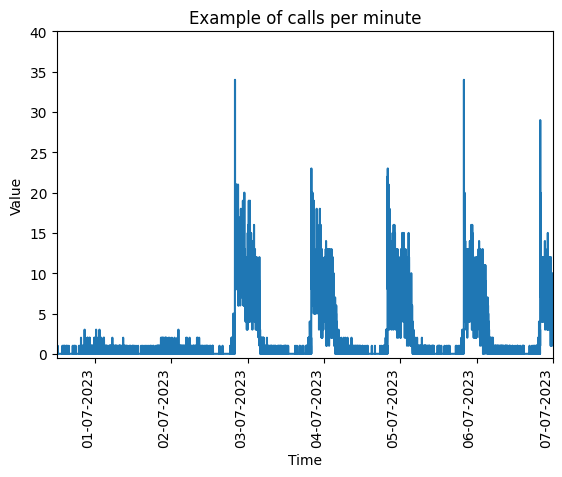

In [35]:
#----------------------------------------
#Plot results
fig, ax = plt.subplots()
ax.plot(OC_freq['date'],OC_freq['value'])
# Change the format of the x-ticks to 'DD-MM-YYYY'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.set_xlim([pd.to_datetime('2023-07-01'), pd.to_datetime('2023-07-07')])
fig.autofmt_xdate()
plt.title('Example of calls per minute')
plt.xlabel('Time')
plt.ylabel('Value')
print(OC_freq['date'].loc[0])
#Example time interval

plt.xticks(rotation=90)
plt.ylim(-0.5,40)
locs, labels = plt.xticks()  # Get the current locations and labels.
# Shift the locations right by 0.5, midday tick
plt.xticks(locs + 0.5)
plt.show()


In [36]:
#--------------------------------------------------
#Read the data again if upper cells are not needed.
OC = pd.read_csv("OC_freq_edited.csv", header=0, 
                 parse_dates=['date'])
OC.set_index('date', inplace=True)
pd.options.display.max_rows = 10
print(OC.head(10))
#------------------------------------------------------------
#Resample minute by minute data to one hour. It will count frequency/hour.
hourly_groups = OC.resample('h')
hourly_data = hourly_groups.sum()
#Modify the quiet hours to zero. Eases the work of AI
hourly_data.loc[hourly_data['value'] < 5, 'value'] = 0
#-----------------------------------------------------------
#Save the data to csv. This data is ready for splitting.
hourly_data.to_csv('OC_hourly_data.csv', index=True)

print(hourly_data)
print(hourly_data.columns)
print(hourly_data.index[0])
len(hourly_data)
print(hourly_data.describe())

                     value
date                      
2021-05-10 08:36:00     11
2021-05-10 08:37:00     26
2021-05-10 08:38:00     14
2021-05-10 08:39:00     26
2021-05-10 08:40:00     26
2021-05-10 08:41:00     18
2021-05-10 08:42:00     24
2021-05-10 08:43:00     22
2021-05-10 08:44:00     24
2021-05-10 08:45:00     25
                     value
date                      
2021-05-10 08:00:00    487
2021-05-10 09:00:00    907
2021-05-10 10:00:00    897
2021-05-10 11:00:00    581
2021-05-10 12:00:00    697
...                    ...
2023-07-20 10:00:00    446
2023-07-20 11:00:00    349
2023-07-20 12:00:00    384
2023-07-20 13:00:00    328
2023-07-20 14:00:00      6

[19231 rows x 1 columns]
Index(['value'], dtype='object')
2021-05-10 08:00:00
              value
count  19231.000000
mean     138.944413
std      244.328655
min        0.000000
25%        0.000000
50%       13.000000
75%       69.000000
max     1377.000000


In [37]:
#------------------------------------------------------------------
#First check if either end or start day is in monday. Delete them.
while hourly_data.index[0].strftime('%A') == "Monday":
     hourly_data = hourly_data.drop(hourly_data.index[0])
while hourly_data.index[-1].strftime('%A') == "Monday":
    hourly_data = hourly_data.drop(hourly_data.index[-1])
while hourly_data.index[0].strftime('%A') != "Monday":
    hourly_data = hourly_data.drop(hourly_data.index[0])
while hourly_data.index[-1].strftime('%A') != "Sunday":
    hourly_data = hourly_data.drop(hourly_data.index[-1])
#--------------------------------------------------------------------
print("HEAD", hourly_data.head(5))
print("--------------")
print("TAIL", hourly_data.tail(5))
print("Hours in data", len(hourly_data), "Days in data", len(hourly_data)/(24), "Weeks in data", len(hourly_data)/(24*7))

HEAD                      value
date                      
2021-05-17 00:00:00      0
2021-05-17 01:00:00      0
2021-05-17 02:00:00      0
2021-05-17 03:00:00      0
2021-05-17 04:00:00      0
--------------
TAIL                      value
date                      
2023-07-16 19:00:00      6
2023-07-16 20:00:00      5
2023-07-16 21:00:00      9
2023-07-16 22:00:00      8
2023-07-16 23:00:00      5
Hours in data 18984 Days in data 791.0 Weeks in data 113.0


In [38]:
#Normalizing function with min max.
# Normalizing works both ways, transformation of data to and from normal.
#------------------------------------------------------------------------
def normalize_denormalize(data,y_max,y_min,denormalize):
    if denormalize: #Denormalize the data
        return data * (y_max - y_min) + y_min
    else: #Normalize the data.
        return data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#-------------------------------------------------------------------------       
#This checks if data is already normalized. If so, this is skipped.
if np.max(hourly_data['value'])>1.1:
    print("Normalized")
    hourly_data_backup = copy.deepcopy(hourly_data)
    hourly_data = normalize_denormalize(hourly_data, np.max(hourly_data_backup),np.min(hourly_data_backup),False)
#-----------------------------------------------------------------------------------------------------------------
print(hourly_data)


Normalized
                        value
date                         
2021-05-17 00:00:00  0.000000
2021-05-17 01:00:00  0.000000
2021-05-17 02:00:00  0.000000
2021-05-17 03:00:00  0.000000
2021-05-17 04:00:00  0.000000
...                       ...
2023-07-16 19:00:00  0.004357
2023-07-16 20:00:00  0.003631
2023-07-16 21:00:00  0.006536
2023-07-16 22:00:00  0.005810
2023-07-16 23:00:00  0.003631

[18984 rows x 1 columns]


In [39]:
#------------------
#Split function gets the nearest split that the data can be splitted into. Splitting is used for train/test data in machine learning.
print(hourly_data)
def get_split(days, day):
    print("test", days)
    for i in range(int(days/10), int(days)):
        if i % day == 0:
            print("TULOS", i, day)
            return i
    return Thereserror
def parity(hourly_data, divisor):
    #if len(hourly_data)%divisor != 0:
    #    print("why not")
    while hourly_data.index[0].strftime('%A') == "Monday":
        hourly_data = hourly_data.drop(hourly_data.index[0])
    while hourly_data.index[0].strftime('%A') != "Monday":
        hourly_data = hourly_data.drop(hourly_data.index[0])

        #hourly_data = parity(hourly_data, divisor)
    #else:
     #   print(len(hourly_data))
        #return hourly_data
    return hourly_data
#----------------------------------------------
#Day defines how many days will be predicted. IMPORTANT
day = 7
if day %2 == 0:
    hourly_data = parity(hourly_data, 2)
#----------------------------------------------
print("Full days",(hourly_data.shape[0]/24))
sday = hourly_data.index[0]
eday = hourly_data.index[-1]
print("Starting day: ",sday,sday.strftime('%A'),  " Ending day: ", eday,eday.strftime('%A'))
#-------------------------------------------------------------------------------------------
#Split value depends on full days. They have to be divisible by day count (typically 7,14,21,28 etc).
test = ((get_split(hourly_data.shape[0]/24, day))+(0))
#Train and test sets are splitted
train,test = train_test_split(hourly_data, test_size= test/(hourly_data.shape[0]/24) ,shuffle=False) #No shuffling for time series.
#-----------------------------------------------------------
#Lengths are used to to reshape the training and test sets.
lengthtr = copy.deepcopy(len(train))
lengthte = copy.deepcopy(len(test))
#-----------------------------------------------------------
#Reshape
train = train['value'].values.reshape((int((lengthtr/(24*day))), 24*day, 1))
print(train.shape, test.shape)
test = test['value'].values.reshape((int((lengthte/(24*(day)))), 24*day, 1))
#-------------------------------------------------------------
print("Train and Test shape")
print(train.shape, test.shape)

                        value
date                         
2021-05-17 00:00:00  0.000000
2021-05-17 01:00:00  0.000000
2021-05-17 02:00:00  0.000000
2021-05-17 03:00:00  0.000000
2021-05-17 04:00:00  0.000000
...                       ...
2023-07-16 19:00:00  0.004357
2023-07-16 20:00:00  0.003631
2023-07-16 21:00:00  0.006536
2023-07-16 22:00:00  0.005810
2023-07-16 23:00:00  0.003631

[18984 rows x 1 columns]
Full days 791.0
Starting day:  2021-05-17 00:00:00 Monday  Ending day:  2023-07-16 23:00:00 Sunday
test 791.0
TULOS 84 7
(101, 168, 1) (2016, 1)
Train and Test shape
(101, 168, 1) (12, 168, 1)


In [40]:
def forecast(model, history, n_input):
    #---------------------------------
    # flatten data for model.
    data = array(history)
    #print("Shape here", np.shape(data))
    #Reshape it again for model.
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data, reshape it.
    input_x = data[-n_input:, 0]
    input_x = input_x.reshape((1, len(input_x), 1))
    input_x = np.transpose(input_x)
    #--------------------------------
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast of future values.
    yhat = yhat[0]
    #--------------------------------
    #Return predictions
    return yhat
#------------------------------------------------------------------------
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each time
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    #--------------------------------------------------------
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    #-------------------------------------------------------
    return score, scores
#---------------------------------------------------------------------------------
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
#---------------------------------------------------------------------------------
# convert history into inputs and outputs. Supervised learning requires input and correct answer.
def to_supervised(train, n_input, n_out=48*day): #Output depends on how many days are wanted.
    # flatten data again!
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    #List the data for easier manipulation.
    X, y = list(), list() 
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)
#-------------------------------------------------------------------------------------
def evaluate_model(train, test, n_input):
    # fit the model
    model, historia = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, historia
#---------------------------------------------------------------------------------------

In [41]:
# univariate multi-step lstm teaching module!

# train the model
def build_model(train, n_input):
    # prepare data
    #train_x, train_y = to_supervised(train, n_input) # Windowing, making more data.
    train_x = copy.deepcopy(train)
    train_y = np.transpose(copy.deepcopy(train_x))
    train_y = train_x.reshape((train.shape[0], train.shape[1]))
    # define parameters
    verbose, epochs, batch_size = 0, 70, 1
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    print("WHAT IS OUTPUTS", n_outputs, n_features, n_timesteps)
    print(np.shape(train_x),np.shape(train_y))
    
    # define model
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model = Sequential()
    model.add(LSTM(672, activation='relu', input_shape=(n_timesteps, n_features)))

    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Dense(n_outputs))
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer,metrics=['accuracy'])
    #----------------------------------------------------------------------------------
    tf.config.run_functions_eagerly(True)
    
    # storing model training details to analyze later
    callbacks = [
    keras.callbacks.EarlyStopping(monitor="accuracy",
                                  patience=200,
                                  verbose=1,
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='lstm_with_w2v.hdf5',
                                    verbose=1,
                                    save_best_only=True)]
    #Fit the network
    historia = model.fit(train_x,
                    train_y,
                    validation_split=0.33,
                    callbacks=callbacks,
                    batch_size = 1,
                    epochs=35)

    #-----------------------------------------------------------------------------------

    return model, historia


n_input = 24*7 #change input for amount of prior prediction. Now its one week

score, scores, historia = evaluate_model(train, test, n_input)
# summarize scores


WHAT IS OUTPUTS 168 1 168
(101, 168, 1) (101, 168)
Epoch 1/35


C:\Users\koistkos\jupyterlab_files\env\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.03232, saving model to lstm_with_w2v.hdf5
67/67 [==============================] - 103s 2s/step - loss: 0.0409 - accuracy: 0.0000e+00 - val_loss: 0.0323 - val_accuracy: 0.0000e+00
Epoch 2/35


C:\Users\koistkos\jupyterlab_files\env\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 0.03232 to 0.02162, saving model to lstm_with_w2v.hdf5
67/67 [==============================] - 109s 2s/step - loss: 0.0330 - accuracy: 0.0000e+00 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 3/35
67/67 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 0.02162 to 0.01564, saving model to lstm_with_w2v.hdf5
67/67 [==============================] - 102s 2s/step - loss: 0.0254 - accuracy: 0.0000e+00 - val_loss: 0.0156 - val_accuracy: 0.0000e+00
Epoch 4/35
67/67 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.0000e+00
Epoch 4: val_loss improved from 0.01564 to 0.00922, saving model to lstm_with_w2v.hdf5
67/67 [==============================] - 105s 2s/step - loss: 0.0195 - accuracy: 0.0000e+00 - val_loss: 0.0092 - val_accuracy: 0.0588
Epoch 5/35
67/67 [============================

{'loss': [0.04090464487671852, 0.03299897164106369, 0.02541608363389969, 0.01954806223511696, 0.013975994661450386, 0.012386136688292027, 0.00951757375150919, 0.00811699777841568, 0.007419134024530649, 0.0061703333631157875, 0.005482397973537445, 0.005044170189648867, 0.004575168248265982, 0.004120178520679474, 0.004242420196533203, 0.004218880087137222, 0.004005149006843567, 0.0035136407241225243, 0.0037090391851961613, 0.0032948534935712814, 0.003661042544990778, 0.0028470184188336134, 0.003030655672773719, 0.002672047121450305, 0.0028398570138961077, 0.0029391564894467592, 0.0029947650618851185, 0.0024899134878069162, 0.0025025494396686554, 0.0024479778949171305, 0.0025286697782576084, 0.0024009470362216234, 0.002283242763951421, 0.0021164678037166595, 0.0022800667211413383], 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.05970149114727974, 0.13432836532592773, 0.2238806039094925, 0.2985074520111084, 0.35820895433425903, 0.46268656849861145, 0.41791045665740967, 0.6268656849861145, 0.7014925479

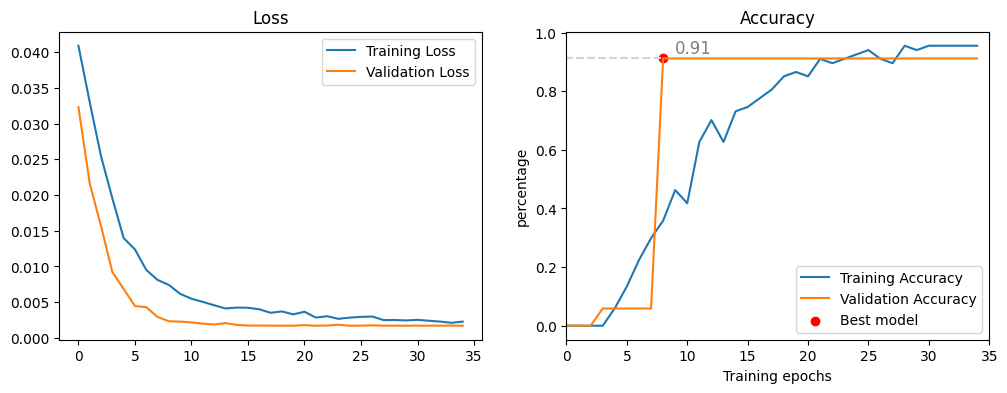

In [45]:
    import datetime
    #Evaluate the model from history. Loss and accuracy are measured.

    print(historia.history)

    print("DID WE FINISH")
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(historia.history['loss'], label='Training Loss')
    plt.plot(historia.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(historia.history['accuracy'], label='Training Accuracy')
    plt.plot(historia.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')


    print(np.where(historia.history['val_accuracy']==np.max(historia.history['val_accuracy']))[0][0])
    plt.scatter(np.where(historia.history['val_accuracy']==np.max(historia.history['val_accuracy']))[0][0],np.max(historia.history['val_accuracy']), color = "red", label="Best model")
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel("Training epochs")
    plt.ylabel("percentage")
    plt.hlines(np.max(historia.history['val_accuracy']), -1,
               np.where(historia.history['val_accuracy']==np.max(historia.history['val_accuracy']))[0][0],
               color="lightgrey", linestyle="dashed",zorder=1)
    plt.xlim(0,len(historia.history['val_accuracy']))
    plt.text(12, np.max(historia.history['val_accuracy'])*1.02, str(round(np.max(historia.history['val_accuracy']),2)), fontsize=12, ha='right', color='grey')
    from datetime import datetime

# Your code here

    plt.savefig("Loss_accuracy" + datetime.now().strftime("%H%M%S") + ".png", dpi=600)
    plt.show()

(11760,) (11760,)


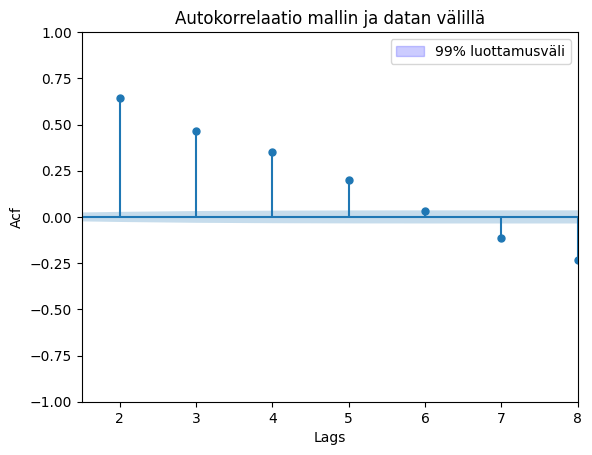

In [172]:
#LSTM cnn deep neural network model vs. data ....

lstm: [0.048] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


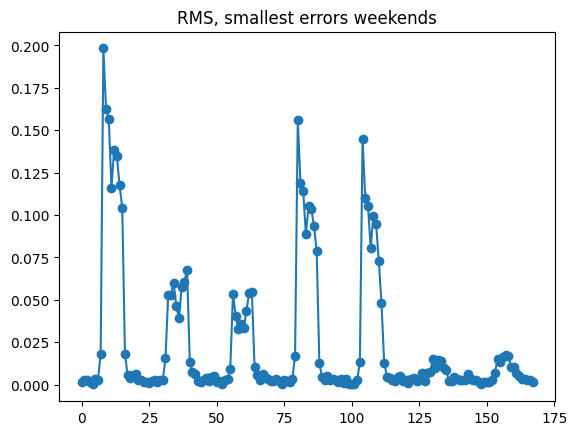

In [46]:
#Transform data back, denormalize.
if np.max(hourly_data)>5:
    hourly_data = normalize_denormalize(hourly_data, np.max(hourly_data_backup),np.min(hourly_data_backup),True)

summarize_scores('lstm', score, scores)
# plot scores

hours = np.arange(0,day*24)

pyplot.plot(hours, scores, marker='o', label='lstm')
plt.title("RMS, smallest errors weekends")
pyplot.show()

length of train set:  101 (101, 168, 1)
Start of train set: 2021-05-17 00:00:00 End of train set: 2023-04-24 00:00:00
Start of test set: 2023-04-24 00:00:00 End of test set: 2023-07-16 23:00:00
HISTORY (113, 168, 1)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112]
history here (113, 168, 1) (101, 168, 1) (12, 168, 1) (113, 168, 1)
weeknumber [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  

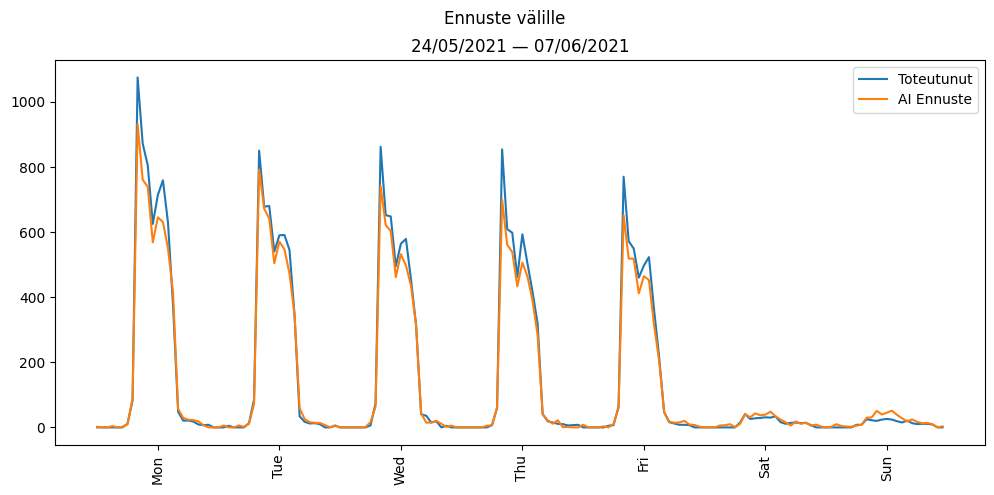

In [48]:
#HUOM HUOM HUOM! Ennusteen teko riippuu inputin koosta! Esim input on 2 viikkoa, n = 2
n=2


from datetime import datetime
def array_to_date(start_date,step):

    return start_date + timedelta(weeks=int(step))
#history = [x for x in train]
print("length of train set: ", len(train), np.shape(train))
print("Start of train set:", sday, "End of train set:", sday + timedelta(days=len(train)*7))
print("Start of test set:",  sday + timedelta(days=len(train)*7), "End of test set:", eday)
#Load the model
model = load_model('lstm_with_w2v.hdf5')
print(model)
#Copy train and test sets into one array.---
pitka_ennuste = copy.deepcopy(train)
pitka_ennuste = np.vstack((pitka_ennuste, test))
#print(pitka_ennuste)
#print("HISTORY", np.shape(history))
print("HISTORY", np.shape(pitka_ennuste))
#---------------------------------------
#Get daynumbers and weeknumbers for forecasting..
daynumber = np.arange(0,len(hourly_data)/24)
#print("daynumber", daynumber)
weeknumber = np.arange(0,daynumber[-1]/7, dtype=int)
print(weeknumber)
#----------------------------------------
#Daylist is used to get day names for plotting.
daylist=[]
i=0
while i<7: #Leave this as 7
    daylist = np.append(daylist, (sday + timedelta(weeks=len(weeknumber))+ timedelta(days=i)).strftime('%a'))
    i=i+1
# History is set up from pitka_ennuste.

#tässä on joku hämminki nyt.
history = [x for x in pitka_ennuste]
#print("hämmingin jälkeen", history)

#history = [inner_array.tolist() for inner_array in history]
#print(history)
print("history here", np.shape(pitka_ennuste), np.shape(train), np.shape(test), np.shape(history))
ennuste = []
i=0
#----------------------------------------
#Number of weeks to be forecasted.
daylist0 = copy.deepcopy(daylist)
weeks = day/7
#Which weeks to plot prior the prediction. Can choose several weeks.
print("weeknumber", weeknumber)
ea1 = weeknumber[-12] // n
ea2 = weeknumber[-11] // n
print(ea1,ea2, len(train), np.shape(train))

print("Prediction is made from data from date", array_to_date(sday, ea1), " to ", array_to_date(sday, ea2+1))
i=0
while i<weeks + ea2-ea1:
    if weeks != 1:
        daylist = np.append(daylist,daylist0)
    i=i+1
i=0

#--------------------------------------------------------------------------------------------------Forecast
#Forecast
while i<weeks: #
    testi = forecast(model, history[ea1:ea2], 24*day)
    ennuste = np.append(ennuste,testi)
    #if weeks != 1:
     #   daylist = np.append(daylist,daylist0)
    i=i+1
print("Daylist", daylist)
#If forecast has very low negative numbers, they are just changed to zero..
for i in range(len(ennuste)):
    if ennuste[i]<0:
        ennuste[i]=0
#denormalize the data
if np.max(ennuste)<5:
    ennuste = normalize_denormalize(ennuste, np.max(hourly_data_backup),np.min(hourly_data_backup),True)

#Then just plotting.----------------------------------------------------------------------------------------------
testi = copy.deepcopy(ennuste)
hist = [item for sublist in history[ea1:ea2] for item in sublist]
if np.max(hist)<1.1:
    hist = array([item for sublist in hist for item in sublist])
    hist = normalize_denormalize(hist, np.max(hourly_data_backup),np.min(hourly_data_backup),True)

plt.figure(figsize=(12, 5))
plt.title(str((sday + timedelta(weeks=weeks)).date().strftime('%d/%m/%Y'))+" — " +str((sday + timedelta(weeks=weeks+1+ea2-ea1)).date().strftime('%d/%m/%Y')))
plt.suptitle("Ennuste välille")
plt.plot(hist, label="Toteutunut")
plt.plot(testi, label="AI Ennuste")
print(np.arange(0,day*24*weeks,24), daylist)
plt.xticks(np.arange(0,day*24*(weeks),24),daylist,rotation=90)
current_ticks = plt.xticks()[0]
plt.xticks(current_ticks + 12, daylist, rotation=90)
plt.legend()

#plt.xlim(0,36)
plt.savefig("Ennuste" + datetime.now().strftime("%H%M%S")+".png",dpi=600)
plt.show()

In [137]:
#Validate, how many calls per day?
'''
#Old scatterplot of residuals
i=0
calls_per_day = []
cpd = []
while i<len(testi):
    if i%24==0:
        calls_per_day = np.append(calls_per_day, np.sum(testi[i:i+23]))
        cpd = np.append(cpd,np.sum(hist[i:i+23]))
    i=i+1
print(calls_per_day, cpd)
residuals = cpd - calls_per_day

plt.scatter(np.arange(0,len(residuals)),residuals)
'''
print(np.shape(history))

(56, 336, 1)


In [49]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.patches as mpatches
from statsmodels.tsa.stattools import acf
#Check autocorrelation for patterns that repeat.
tosi = array(history).flatten()
num_sequences = tosi.shape[0] // day
tosi = tosi[:num_sequences*day].reshape(num_sequences, day)
print(np.shape(history), np.shape(tosi))
ennuste=[]

i=0
while i < 1:#len(history):
    print(i)
    ennuste = np.append(ennuste,forecast(model, history[i:i+day], day))
    if ennuste[i] <0:
        ennuste[i]=0
    i=i+14
print("Ennuste", np.shape(ennuste))
ennuste = normalize_denormalize(ennuste, np.max(hourly_data_backup),np.min(hourly_data_backup),True)
residuals = train - ennuste
residuals = residuals.flatten()
# Create the autocorrelation plot
plot_acf(residuals,use_vlines=True, fft=True) #, lags = 7)
plt.title("Autokorrelaatio mallin ja datan välillä")
confidence_interval_patch = mpatches.Patch(color='blue', alpha=0.2, label='99% luottamusväli')
plt.xlabel("Lags")
plt.ylabel("Acf")
plt.legend(handles=[confidence_interval_patch])
plt.show()
print("Autocorrelation values", acf(residuals))

(113, 168, 1) (2712, 7)
0


ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 168, 1), found shape=(1, 7, 1)

            value
date             
2021-05-16  20533
2021-05-23  25421
2021-05-30  25117
2021-06-06  24160
2021-06-13  23394
...           ...
2021-08-29  26866
2021-09-05  25923
2021-09-12  26015
2021-09-19  24771
2021-09-26  24614

[20 rows x 1 columns]
115


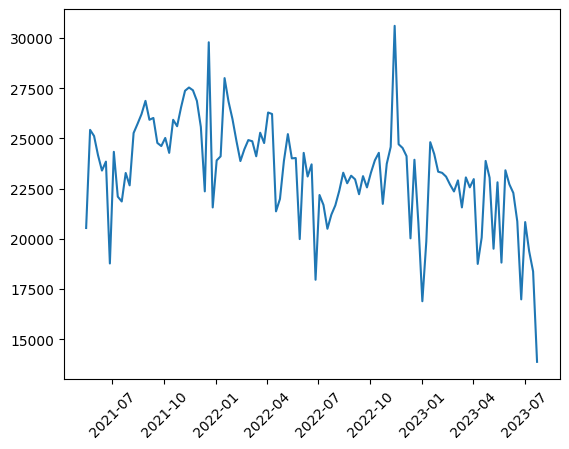

Pearson -0.4938298559397451  p-value: 2.0446080080975022e-08
115


C:\Users\koistkos\jupyterlab_files\env\Lib\site-packages\matplotlib\text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\koistkos\jupyterlab_files\env\Lib\site-packages\matplotlib\text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


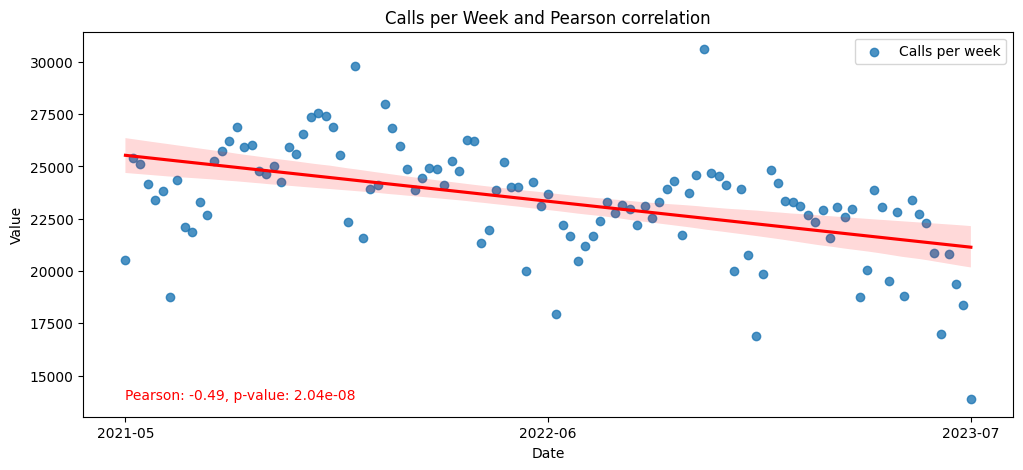

In [236]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.dates as mdates
#Variance and per week investigation!
OC = pd.read_csv("OC_freq_edited.csv", header=0, 
                 parse_dates=['date'])
OC.set_index('date', inplace=True)
pd.options.display.max_rows = 10
weekly_groups = OC.resample('W')
weekly_data = weekly_groups.sum()
weekly_data.to_csv('OC_weekly_data.csv', index=True)
monthly_groups = OC.resample('M')
monthly = monthly_groups.sum()
monthly.to_csv("OC_monthyl_data.csv", index=True)

df = weekly_data.copy()
#----For pearson
numeric_date_index =  mdates.date2num(df.index)
# Convert the numeric date index array back to a pandas Series
numeric_date_series = pd.Series(numeric_date_index, index=df.index)
#correlation_coefficient = df['value'].corr(numeric_date_series)
correlation_coefficient, p_value = stats.pearsonr(numeric_date_series, df['value'])
#-----
df.index = pd.to_numeric(df.index)
df.index = df.index.astype(str).str[:-9]
df.index = df.index.astype(int)

print("Pearson", correlation_coefficient, " p-value:", p_value)
p_value =  f"{p_value:.2e}"
# Perform linear regression using numpy.polyfit
coefficients = np.polyfit(df.index, df['value'], deg=1)
slope, intercept = coefficients
print(len(df))
# Use seaborn's regplot to plot the regression line with errors
plt.figure(figsize=(12, 5))
sns.regplot(x=df.index, y='value', data=df, ci=95, line_kws={"color": "red"}, label = "Calls per week")
plt.xticks([df.index[0], df.index[int(len(df)/2)], df.index[-1]], [weekly_data.index[0].to_period('M'),
                                                                  weekly_data.index[int(len(df)/2)].to_period('M'),
                                                                  weekly_data.index[-1].to_period('M')])
# Customize the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Calls per Week and Pearson correlation')
plt.legend()

plt.text(df.index[0],df.min(), "Pearson: " + str(round(correlation_coefficient,2))+ ", p-value: "+str(p_value), color = "Red")
# Show the plot

plt.savefig("Callsperweek.png", dpi=600, bbox_inches='tight')
plt.show()




In [59]:
print(np.shape(history))
print(history[-6:-5])

(56, 336, 1)
[array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00653595],
       [0.07116921],
       [0.69644154],
       [0.56499637],
       [0.57007988],
       [0.38562092],
       [0.44153958],
       [0.37835875],
       [0.34931009],
       [0.26724764],
       [0.03122731],
       [0.01742919],
       [0.01379811],
       [0.00944081],
       [0.00363108],
       [0.00653595],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00580973],
       [0.05591866],
       [0.58678286],
       [0.4734931 ],
       [0.4422658 ],
       [0.37109659],
       [0.41757444],
       [0.40014524],
       [0.29048656],
       [0.22367466],
       [0.02977487],
       [0.01089325],
       [0.01089325],
       [0.01016703],
       [0.00726216],
       [0.00508351],
       [0.00798838],